In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# choosing color palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

#Data cleaning

In [2]:
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# renaming columns to have all lowercase
survey.columns = [col.lower() for col in survey.columns]

# looking at dtypes, we can see all of them are pandas objects except for age that is int.
print(survey.dtypes)

timestamp                    object
age                           int64
gender                       object
country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object


In [4]:
survey.drop(['timestamp', 'state', 'comments', 'country'], axis= 1, inplace= True)

In [5]:
survey['gender'] = survey['gender'].apply(lambda x: x.lower().strip())

# based on the replies made these lists manually, I hope to not offend anyone.
male = ['male', 'm', 'make', 'cis male', 'man', 'cis man', 'msle', 'malr', 'mail', 'maile', 'something kinda male?', 'ostensibly male, unsure what that really means', 'male-ish', 'guy (-ish) ^_^', 'mal', 'male (cis)']
female = ['female', 'f', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'cis female', 'femail']

def regender(gender_input):
    
    """
    Input: a string about gender
    Output: male, female or other depending on our dictionary
    
    """ 
    if gender_input in male:
        return 'male'
    elif gender_input in female:
        return 'female'
    else:
        return 'other'
    
survey['gender'] = survey['gender'].apply(regender)

# check our final results
survey.gender.value_counts(dropna= False)

gender
male      994
female    247
other      18
Name: count, dtype: int64

In [6]:
# checking for nans
nan_cols = []
for col in survey.columns:
    if survey[col].isnull().sum():
        print(col + ' (%): ' + str(sum(survey[col].isnull())/len(survey)))
        nan_cols += [col]

# nans are present in the self-employed column and in the work_interfere column.
# at most there are 20% of values with nans so we'll replace with 'Don't know'
for col in nan_cols:
    survey[col].fillna("Don't know", inplace= True)

# i'm just gonna drop the rows without age.
survey = survey[survey.age != "Don't know"]

# in the context of our questions we need to drop everyone who is self-employed
print(survey['self_employed'].value_counts())
survey.loc[survey['self_employed'] == 'Yes'] = np.nan
survey.dropna(inplace=True)

self_employed (%): 0.014297061159650517
work_interfere (%): 0.2096902303415409
self_employed
No            1095
Yes            146
Don't know      18
Name: count, dtype: int64


C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\763136699.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey[col].fillna("Don't know", inplace= True)


In [7]:
# getting unique answers for every column
exclude = ['age']
possible_answers = {col:[i for i in survey[col].unique()] for col in survey.columns if col not in exclude}
possible_answers

{'gender': ['female', 'male', 'other'],
 'self_employed': ["Don't know", 'No'],
 'family_history': ['No', 'Yes'],
 'treatment': ['Yes', 'No'],
 'work_interfere': ['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
 'no_employees': ['6-25',
  'More than 1000',
  '26-100',
  '100-500',
  '1-5',
  '500-1000'],
 'remote_work': ['No', 'Yes'],
 'tech_company': ['Yes', 'No'],
 'benefits': ['Yes', "Don't know", 'No'],
 'care_options': ['Not sure', 'No', 'Yes'],
 'wellness_program': ['No', "Don't know", 'Yes'],
 'seek_help': ['Yes', "Don't know", 'No'],
 'anonymity': ['Yes', "Don't know", 'No'],
 'leave': ['Somewhat easy',
  "Don't know",
  'Somewhat difficult',
  'Very difficult',
  'Very easy'],
 'mental_health_consequence': ['No', 'Maybe', 'Yes'],
 'phys_health_consequence': ['No', 'Yes', 'Maybe'],
 'coworkers': ['Some of them', 'No', 'Yes'],
 'supervisor': ['Yes', 'No', 'Some of them'],
 'mental_health_interview': ['No', 'Yes', 'Maybe'],
 'phys_health_interview': ['Maybe', 'No', 'Yes']

In [8]:
def replace_uncertainty(survey_answer):
    """
    Uniformizes all uncertain answers.
    Input: half-answer (string)
    Output: 'Don't know'
    
    """
    
    uncertainty = ['Maybe', 'Some of them', 'Not sure']
    if survey_answer in uncertainty:
        return "Don't know"
    else:
        return survey_answer

# apply function to all columns
for col in survey.columns:
    survey[col] = survey[col].apply(replace_uncertainty)

In [9]:
survey['care_options'] = survey['care_options'].replace(to_replace="Don't know", value= 'No')
survey['care_options'].value_counts()

care_options
No     732
Yes    381
Name: count, dtype: int64

In [10]:
# create a dictionary to map out all the answers in the survey
encoding_dict = {'No': -1, "Don't know": 0, 'Yes': 1,
                 'Never': -2, 'Rarely': -1, 'Sometimes': 1, 'Often': 2,
                 'Very difficult': -2, 'Somewhat difficult': -1, 'Somewhat easy': 1, 'Very easy': 2,
                 '1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5,
                 'male': -1, 'other': 0, 'female': 1}

In [12]:
# made a copy just to check values
survey_coded = survey.copy()

# for each column except the ones not excluded change the values in our dictionary
for col in survey_coded.columns:
    if col not in exclude:
        survey_coded[col] = survey_coded[col].map(encoding_dict)

In [13]:
# let's take a look at our answer-encoded dataframe.
survey_coded

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37.0,1,0,-1,1,2,1,-1,1,1,...,1,1,-1,-1,0,1,-1,0,1,-1
1,44.0,-1,0,-1,-1,-1,5,-1,-1,0,...,0,0,0,-1,-1,-1,-1,-1,0,-1
2,32.0,-1,0,-1,-1,-1,1,-1,1,-1,...,0,-1,-1,-1,1,1,1,1,-1,-1
3,31.0,-1,0,1,1,2,2,-1,1,-1,...,-1,-1,1,1,0,-1,0,0,-1,1
4,31.0,-1,0,-1,-1,-2,3,1,1,1,...,0,0,-1,-1,0,1,1,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26.0,-1,-1,-1,1,0,2,-1,1,-1,...,0,1,-1,-1,0,0,-1,-1,0,-1
1255,32.0,-1,-1,1,1,2,2,1,1,1,...,1,-1,-1,-1,0,1,-1,-1,1,-1
1256,34.0,-1,-1,1,1,1,5,-1,1,1,...,0,-1,1,1,-1,-1,-1,-1,-1,-1
1257,46.0,1,-1,-1,-1,0,3,1,1,-1,...,0,0,1,-1,-1,-1,-1,-1,-1,-1


In [17]:
# make the correlation matrix
correlation = survey_coded.corr()

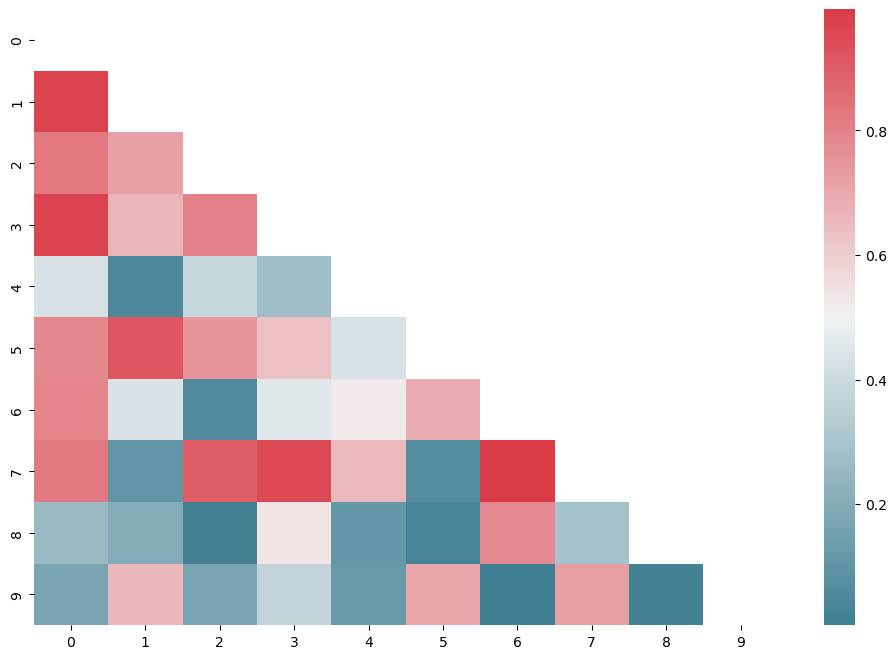

In [20]:
# making a mask to only show half the table cause its duplicated.
correlation = np.random.rand(10, 10)

# Making a mask to only show half the table because it's duplicated
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Replace np.bool with bool

# Choosing colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, cmap=cmap, mask=mask, annot=False)
plt.show()

In [21]:
# define columns to combine
workplace_resources = ['benefits', 
                      'wellness_program', 
                      'anonymity', 
                      'seek_help', 
                      'leave']

willingness = ['coworkers',
               'supervisor',
               'mental_health_interview']

# add columns together
survey_coded['workplace_resources'] = survey_coded.benefits + survey_coded.wellness_program + survey_coded.seek_help + survey_coded.leave + survey_coded.anonymity
survey_coded['willingness'] = survey_coded.coworkers + survey_coded.supervisor + survey_coded.mental_health_interview

In [22]:
def pretty_histogram(data, colname, label, save= False):
    
    """
    Input: data (pandas dataframe), column name (str), x label (str), save (bool)
    Output: a pretty histogram
    """

    hist = sns.distplot(data[colname], 
                        bins = data[colname].max() - data[colname].min() + 1,
                        kde= False,
                        color=flatui[-2],
                        hist_kws= {'range': (data[colname].min(), data[colname].max()),
                                   'rwidth': 0.95,
                                   'alpha': 1})
    
    hist.set(xlabel= label, ylabel= 'Count')
    sns.despine()
    
    if save:
        figure = hist.get_figure()
        figure.savefig('figures/' + colname + "_hist.png")

C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\2909174654.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  hist = sns.distplot(data[colname],


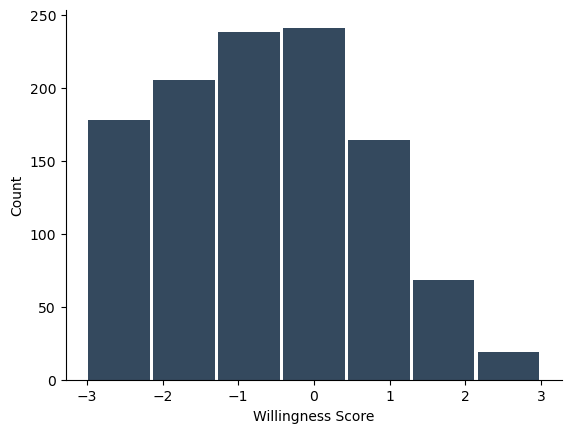

In [23]:
# make a histogram for our newly created 'Willingness' variable.
pretty_histogram(survey_coded, 'willingness', 'Willingness Score', save= False)

In [25]:
# interestingly to check the proportion of people aware of services I needed to recode the values in the
# care options column from 'No' = -1 to 'No' = 0
survey_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)
survey_coded.pivot_table(index=['workplace_resources'], values=['care_options'], aggfunc= lambda x: sum(x)/len(x))

C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\2671658955.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)


,care_options
workplace_resources,
-6,0.400000
-5,0.441176
-4,0.325581
-3,0.215686
-2,0.180000
-1,0.180412
0,0.252809
1,0.377358
2,0.428571


C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\3430847003.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bars = sns.barplot(x='workplace_resources', y='care_options', data= survey_coded,


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Shivam Singh\\figures\\resources_and_awareness.png'

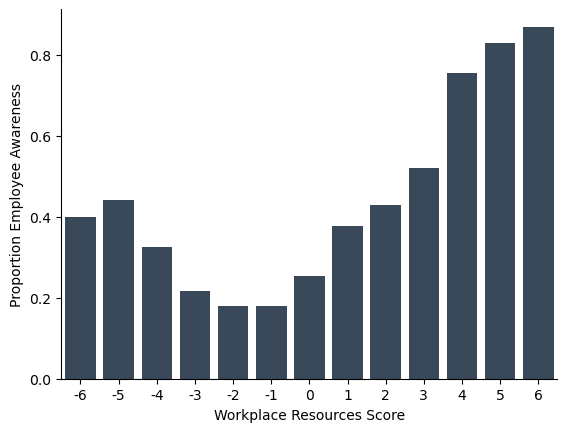

In [26]:
# plot proportions of people that know about care options for each score of workplace resource.

label = 'Workplace Resources Score'

bars = sns.barplot(x='workplace_resources', y='care_options', data= survey_coded, 
                   ci= None, color= flatui[4])

bars.set(xlabel= label, ylabel= 'Proportion Employee Awareness')
sns.despine()
figure = bars.get_figure()
figure.savefig('figures/resources_and_awareness.png')

In [27]:
# group by variable of interest, create a label and rename columns
family_data = survey_coded.groupby('family_history').agg({'willingness':'mean'}).reset_index()
family_data['label'] = ['Family History']*len(family_data)
family_data.rename(columns= {'family_history':'Answer'}, inplace=True)

treatment_data = survey_coded.groupby('treatment').agg({'willingness':'mean'}).reset_index()
treatment_data['label'] = ['Treatment']*len(treatment_data)
treatment_data.rename(columns= {'treatment':'Answer'}, inplace=True)

willingness_variables = pd.concat([family_data, treatment_data], axis=0)
willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)
willingness_variables.Answer.replace(to_replace=1, value='Yes', inplace=True)

C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\3362891454.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Shivam Singh\\figures\\history_treatment_willingness.png'

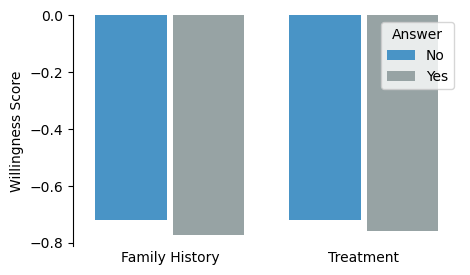

In [28]:
# making a category bar plot
fig, ax = plt.subplots(figsize=(5, 3))

bars= sns.barplot(x="label", y="willingness", hue="Answer", 
            palette= sns.color_palette(flatui[1:3]), 
            data=willingness_variables)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


change_width(ax, .37)
sns.despine(bottom=True)
bars.set(xlabel= '', ylabel= 'Willingness Score')
bars.tick_params(axis='x', which='both', length=0)
figure = bars.get_figure()
figure.savefig('figures/history_treatment_willingness.png')

C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\797012715.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  bars = sns.barplot(x= 'work_interfere', y= 'willingness', data= survey_coded, color= flatui[-1], errwidth=0.75)
C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\797012715.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bars.set(xlabel= xlabel, ylabel= ylabel, xticklabels=['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'])
C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\797012715.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=30)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Shivam Singh\\figures\\work_interfere_willingness.png'

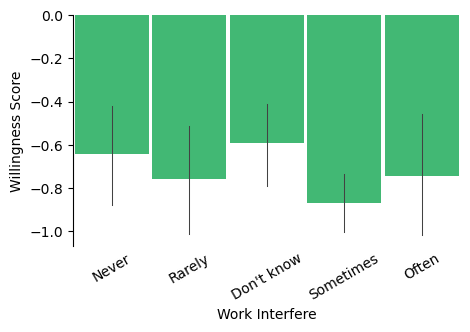

In [29]:
xlabel = 'Work Interfere'
ylabel = 'Willingness Score'

fig, ax = plt.subplots(figsize=(5, 3))
bars = sns.barplot(x= 'work_interfere', y= 'willingness', data= survey_coded, color= flatui[-1], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel, xticklabels=['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'])
bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=30)
bars.set()
sns.despine(bottom= True)
change_width(ax, .95)
bars.tick_params(axis='x', which='both', length=0)

figure = bars.get_figure()
figure.savefig('figures/work_interfere_willingness.png')

In [30]:
# I also did this analysis for gender but I find it slightly less interesting.
gender_willingness = survey_coded.groupby('gender').agg({'willingness':'mean'})
gender_willingness

,willingness
gender,
-1,-0.662857
0,-0.615385
1,-1.053333


In [31]:
# to reach the answer to our main question
willingness_treatment = survey_coded.groupby('workplace_resources').agg({'willingness':'mean'})
willingness_treatment

,willingness
workplace_resources,
-6,-2.600000
-5,-1.323529
-4,-1.046512
-3,-1.333333
-2,-0.820000
-1,-0.788660
0,-0.752809
1,-0.641509
2,-0.448980


C:\Users\Shivam Singh\AppData\Local\Temp\ipykernel_36372\1621852444.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  bars = sns.barplot(x='workplace_resources', y='willingness', data= survey_coded,


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Shivam Singh\\figures\\resources_willingness.png'

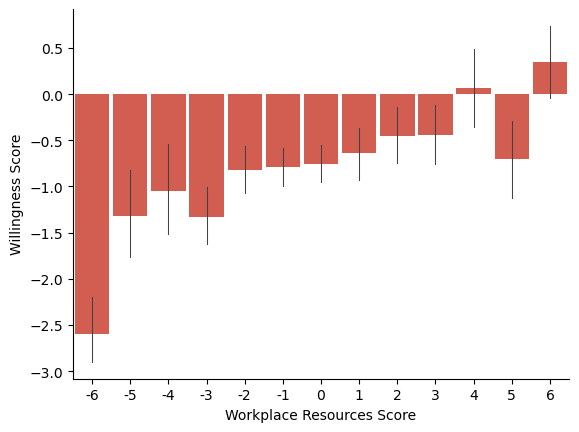

In [32]:
# create a bar plot with the average willingness score for each workplace resourses category
xlabel = 'Workplace Resources Score'
ylabel = 'Willingness Score'

fig, ax = plt.subplots()
bars = sns.barplot(x='workplace_resources', y='willingness', data= survey_coded, 
                   color= flatui[3], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel)
sns.despine()
change_width(ax, .9)
figure = bars.get_figure()
figure.savefig('figures/resources_willingness.png')

In [33]:
# linear regression
x = survey_coded['workplace_resources']
y = survey_coded['willingness']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print ('The slope is: ' + str(slope))
print ('The intercept is: ' + str(intercept))
print ('The r_value is: ' + str(r_value**2))
print ('The std error is: ' + str(std_err))
print(p_value)

The slope is: 0.12654645137988493
The intercept is: -0.730097437344808
The r_value is: 0.04557515247705056
The std error is: 0.017373997118904586
6.142383368314783e-13


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Shivam Singh\\figures\\resources_willingness_regplot.png'

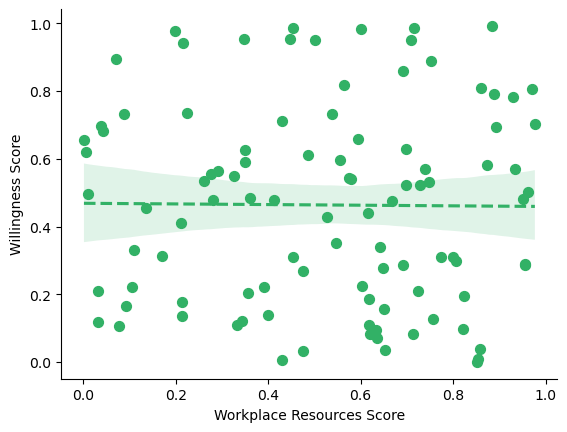

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming `x` and `y` are defined as lists or NumPy arrays
x = np.random.rand(100)
y = np.random.rand(100)

# Defining the color palette (replace `flatui` with your specific palette)
flatui = sns.color_palette("husl", 8)

# Plot labels
xlabel = 'Workplace Resources Score'
ylabel = 'Willingness Score'

# Creating the regression plot
reg = sns.regplot(x=x, y=y, x_estimator=np.mean,
                  scatter_kws={'color': flatui[3]}, 
                  line_kws={'color': flatui[3], 'ls': 'dashed'})

# Setting labels
reg.set(xlabel=xlabel, ylabel=ylabel)

# Removing the top and right spines from the plot
sns.despine()

# Saving the figure
figure = reg.get_figure()
figure.savefig('figures/resources_willingness_regplot.png')

# Show the plot
plt.show()
